In [14]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import h5py
import matplotlib.pyplot as plt
from numpy.random import RandomState
from numpy import unravel_index


import time


In [15]:
# ori_train = pd.read_csv('train.csv')
# ori_test = pd.read_csv('test.csv')
# ori_val = pd.read_csv('validation.csv')
# def split_useragent_os(data):
#     return data.split('_')[0]
# def split_useragent_b(data):
#     return data.split('_')[1]
# def split_useragent(dataframe):
#     dataframe['os'] = dataframe['useragent'].apply(split_useragent_os)
#     dataframe['browser'] = dataframe['useragent'].apply(split_useragent_b)
#     dataframe.drop(['useragent'], axis=1, inplace=True)

# split_useragent(ori_train)
# split_useragent(ori_test)
# split_useragent(ori_val)

# ori_train['logtype']='2'
# ori_test['logtype']='2'
# ori_val['logtype']='2'

# ori_train.to_csv('train1.csv')
# ori_test.to_csv('test1.csv')
# ori_val.to_csv('val1.csv')
# df_train_original = pd.read_csv('train.csv')
# df_validation_original = pd.read_csv('validation.csv')
# df_test_original = pd.read_csv('test.csv')

# # split os and browser
# def split_useragent_os(data):
#     return data.split('_')[0]
# def split_useragent_b(data):
#     return data.split('_')[1]
# def split_useragent(dataframe):
#     dataframe['os'] = dataframe['useragent'].apply(split_useragent_os)
#     dataframe['browser'] = dataframe['useragent'].apply(split_useragent_b)
#     dataframe.drop(['useragent'], axis=1, inplace=True)

# split_useragent(df_train_original)
# split_useragent(df_validation_original)
# split_useragent(df_test_original)

# #drop meaningless columns and the columns not in testdata
# col_to_drop1 = ['city','slotid','slotprice','IP','domain','usertag','creative','bidid','userid','url','urlid','bidprice','payprice','keypage']
# test_to_drop = ['city','slotid','slotprice','IP','domain','usertag','creative','bidid','userid','url','urlid','keypage']
# df_train = df_train_original.drop(col_to_drop1, axis=1)
# df_validation = df_validation_original.drop(col_to_drop1, axis=1)
# df_test = df_test_original.drop(test_to_drop, axis=1)

# #make the catagorical data into one hot format : eg monday ->[ 1, 0, 0 ,0 ,0 ,0 ,0 ]
# def onehot(onehot_df, column_name):
#     dummies = pd.get_dummies(onehot_df[column_name],prefix=column_name)
#     onehot_df = onehot_df.join(dummies)
#     onehot_df = onehot_df.drop([column_name], axis=1)
#     return onehot_df
# column_to_onehot = ['weekday','hour','region','adexchange','slotformat','os','browser','slotwidth','slotheight','slotvisibility']
# for col_name in column_to_onehot:
#     df_train = onehot(df_train, col_name)
#     df_validation = onehot(df_validation, col_name)
#     x_test = onehot(df_test, col_name)

# x_train = df_train.drop('click',axis =1 )
# x_val   = df_validation.drop('click',axis =1 )

# print(x_train.shape)
# print(x_val.shape)
# print(x_test.shape)

# x_train.to_csv('train_notag.csv')
# x_val.to_csv('val_notag.csv')
# x_test.to_csv('test_notag.csv')
# print('save data_notag train val test end')
    
# usertag_train = pd.read_csv('tag_train.csv')
# usertag_test = pd.read_csv('tag_test.csv')
# usertag_val = pd.read_csv('tag_val.csv')

# drop_train = pd.concat([df_train, usertag_train], axis=1, join_axes=[df_train.index])
# drop_val = pd.concat([df_validation, usertag_val], axis=1, join_axes=[df_validation.index])
# x_test = pd.concat([df_test, usertag_test], axis=1, join_axes=[df_test.index])
# print('join usertag end')

# x_train = drop_train.drop('click',axis =1 )
# x_val   = drop_val.drop('click',axis =1 )

# print(x_train.shape)
# print(x_val.shape)
# print(x_test.shape)

# x_train.to_csv('train5.csv')
# x_val.to_csv('val5.csv')
# x_test.to_csv('test5.csv')
# print('save model_used train val test end')

ori_train = pd.read_csv('train1.csv')
ori_test = pd.read_csv('test1.csv')
ori_val = pd.read_csv('val1.csv')

x_train = pd.read_csv('train5.csv')
x_test = pd.read_csv('test5.csv')
x_val = pd.read_csv('val5.csv')

In [16]:
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [17]:
y_train = ori_train['click'].values
y_val = ori_val['click'].values

In [18]:
x_train,x_valid,y_train,y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)
print('Train samples: {} Validation samples: {}'.format(len(x_train), len(x_valid)))

Train samples: 1944784 Validation samples: 486197


In [19]:
x_train = xgb.DMatrix(x_train, y_train)
x_valid = xgb.DMatrix(x_valid, y_valid)
x_val = xgb.DMatrix(x_val)
x_test = xgb.DMatrix(x_test)

In [20]:
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.02
params['silent'] = True
params['max_depth'] = 6
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9

In [21]:
def gini(actual,pred,cmpcol = 0,sortcol = 1):
    assert(len(actual)== len(pred))
    all = np.asarray(np.c_[actual,pred,np.arange(len(actual))],dtype = np.float)
    all = all[np.lexsort((all[:,2],-1*all[:,1]))]
    totallosses = all[:,0].sum()
    ginisum = all[:,0].cumsum().sum()/totallosses
    
    ginisum -= (len(actual)+1)/2
    return ginisum/len(actual)
def gini_normalized(a,p):
    return gini(a,p)/gini(a,a)
def gini_xgb(preds,dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels,preds)
    return [("gini",gini_score)]

In [22]:
# watchlist = [(x_train, 'train'), (x_valid, 'valid')]
# model_xgb = xgb.train(params, x_train, 3000, watchlist,
#                       feval=gini_xgb, early_stopping_rounds=150, maximize=True, verbose_eval=10)

[0]	train-error:0.000739	valid-error:0.000699	train-gini:0.208228	valid-gini:0.258929
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 150 rounds.
[10]	train-error:0.000747	valid-error:0.000701	train-gini:0.350845	valid-gini:0.382296
[20]	train-error:0.000737	valid-error:0.000701	train-gini:0.350677	valid-gini:0.38287
[30]	train-error:0.000717	valid-error:0.000689	train-gini:0.350678	valid-gini:0.382871
[40]	train-error:0.000717	valid-error:0.000685	train-gini:0.351091	valid-gini:0.383934
[50]	train-error:0.000716	valid-error:0.000685	train-gini:0.495173	valid-gini:0.546799
[60]	train-error:0.000715	valid-error:0.000683	train-gini:0.49561	valid-gini:0.547099
[70]	train-error:0.000713	valid-error:0.000681	train-gini:0.497101	valid-gini:0.548726
[80]	train-error:0.000712	valid-error:0.000681	train-gini:0.549932	valid-gini:0.582312
[90]	train-error:0.00071	valid-error:0.000681	train-gini:0.554747	valid-gi

In [23]:
model_xgb.save_model('xg2.model')

In [30]:
bst_new=xgb.Booster({'nthread':4})
bst_new.load_model('xg2.model')

In [25]:
avgCTR= ori_val['click'].mean()
bidbase = 97

In [36]:
val_pred = model_xgb.predict(x_val)

In [38]:
val_pred

array([  1.74091576e-04,   9.35150092e-05,   8.45452159e-05, ...,
         1.33164530e-03,   4.48342093e-04,   3.55034921e-04], dtype=float32)

In [34]:
ori_val.shape

(303925, 29)

In [40]:
import numpy as np
from sklearn.metrics import roc_auc_score
y_true = ori_val['click']
y_pre = val_pred
auc_val_xg1 = roc_auc_score(y_true, y_pre)
auc_val_xg1

0.87973917772848198

In [41]:
val_pred = pd.DataFrame(val_pred)
val_pred[0]

0         0.000174
1         0.000094
2         0.000085
3         0.000202
4         0.000058
5         0.000328
6         0.000293
7         0.000472
8         0.000169
9         0.000148
10        0.000305
11        0.000307
12        0.000134
13        0.000456
14        0.000194
15        0.000087
16        0.000167
17        0.000125
18        0.000730
19        0.000087
20        0.000459
21        0.000299
22        0.000209
23        0.000073
24        0.000729
25        0.000525
26        0.000038
27        0.000696
28        0.000146
29        0.000351
            ...   
303895    0.002357
303896    0.000146
303897    0.001599
303898    0.001156
303899    0.000328
303900    0.001958
303901    0.000143
303902    0.000451
303903    0.000132
303904    0.000289
303905    0.000219
303906    0.000190
303907    0.000180
303908    0.000177
303909    0.000205
303910    0.000275
303911    0.000823
303912    0.000223
303913    0.000594
303914    0.000084
303915    0.000707
303916    0.

In [127]:
avgCTR= ori_train['click'].mean()
bidbase = 120
val_pred['pre_click'] = val_pred[0]
val_pred['unitprice'] = val_pred['pre_click'] /avgCTR
val_pred['bidprice'] =val_pred['pre_click'] /avgCTR * bidbase
val_pred['payprice'] = ori_val['payprice']
val_pred['click'] = ori_val['click']
val_pred['advertiser'] = ori_val['advertiser']
buyyed = val_pred[val_pred['bidprice']>= val_pred['payprice']]
# trainv['click'].count()
val_pred.head(5)

,0,payprice,click,pre_click,unitprice,bidprice,advertiser
0,0.000174,23,0,0.000174,0.236036,28.324371,1458
1,0.000094,75,0,0.000094,0.126789,15.214716,3476
2,0.000085,65,0,0.000085,0.114628,13.755347,3358
3,0.000202,6,0,0.000202,0.273974,32.876861,3358
4,0.000058,5,0,0.000058,0.078251,9.390134,3476


In [128]:
def evaluate(data):
    buyyed = data[data['bidprice']>= data['payprice']]
    ctr,clicks,cost = buyyed['click'].mean(),buyyed['click'].sum(),buyyed['payprice'].sum()
    CPC = cost/clicks/1000
    CPM = cost /buyyed['click'].count() *1000
    return ctr,clicks,cost,CPC,CPM 
eval_val = evaluate(val_pred)
eval_val

(0.001218434920344817, 160, 5838935, 36.49334375, 44464.764385147275)

In [49]:
x_preds = model_xgb.predict(x_test) 

In [51]:
x_preds = pd.DataFrame(x_preds)
x_preds[0]

0         0.000752
1         0.000960
2         0.000082
3         0.000365
4         0.000499
5         0.000561
6         0.000158
7         0.000614
8         0.000152
9         0.000199
10        0.000336
11        0.001765
12        0.000537
13        0.000306
14        0.000382
15        0.000212
16        0.000325
17        0.000157
18        0.000368
19        0.000346
20        0.000119
21        0.000526
22        0.000157
23        0.000148
24        0.000040
25        0.001159
26        0.000151
27        0.000488
28        0.000467
29        0.000051
            ...   
303345    0.000283
303346    0.000442
303347    0.000263
303348    0.000259
303349    0.000324
303350    0.000187
303351    0.000618
303352    0.000515
303353    0.006351
303354    0.000179
303355    0.000113
303356    0.000473
303357    0.000116
303358    0.000129
303359    0.000144
303360    0.000224
303361    0.000154
303362    0.000653
303363    0.000554
303364    0.000258
303365    0.000186
303366    0.

In [54]:
avgCTR= ori_train['click'].mean()
bidbase = 97
x_preds['pre_click'] = x_preds[0]
x_preds['unitprice'] = x_preds['pre_click'] /avgCTR
x_preds['bidprice'] =x_preds['pre_click'] /avgCTR * bidbase
x_preds['payprice'] = ori_val['payprice']
x_preds['click'] = ori_val['click']
x_preds['advertiser'] = ori_val['advertiser']
buyyed = x_preds[x_preds['bidprice']>= x_preds['payprice']]
# trainv['click'].count()
x_preds.head(5)

,0,pre_click,unitprice,bidprice,payprice,click,advertiser
0,0.000752,0.000752,1.019547,98.896084,23,0,1458
1,0.000960,0.000960,1.301683,126.263211,75,0,3476
2,0.000082,0.000082,0.111654,10.830454,65,0,3358
3,0.000365,0.000365,0.494513,47.967741,6,0,3358
4,0.000499,0.000499,0.676984,65.667424,5,0,3476


In [55]:
xg_test = pd.DataFrame(x_preds['bidprice'].tolist(), index = ori_test["bidid"], columns=["bidprice"])
xg_test.to_csv('下午xg.csv', header=True, index_label='bidid')

In [56]:
xg_test

,bidprice
bidid,
366c563de7d90feb9d4dab53e795a93fb3157387,98.896084
29167d4caa719788b5a342dbaa25151d53121f80,126.263211
ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,10.830454
844c2da00d45315f20b748ec131c26ee99a7cbc7,47.967741
c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,65.667424
7493c42f6d8f29d9f414b75c125ce3db40461ef9,73.763034
819fb6958ea48b10430710d009c57d55a31debcb,20.775643
8660774f6c94e32dfbd46add8a9bc94df3c74130,80.700176
ccc4c75ae4fd33526e5ecdae482c45c1dabc94db,20.022946


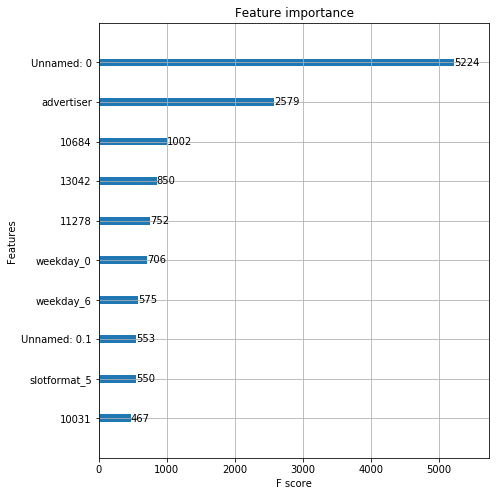

In [68]:
fig, ax = plt.subplots(1,1,figsize=(7,8))
xgb.plot_importance(model_xgb, max_num_features=10, ax=ax)

In [58]:
pd.Series(model_xgb.get_fscore()).sort_values(ascending=False)

Unnamed: 0          5224
advertiser          2579
10684               1002
13042                850
11278                752
weekday_0            706
weekday_6            575
Unnamed: 0.1         553
slotformat_5         550
10031                467
10063                450
10111                413
os_windows           392
slotvisibility_1     362
weekday_2            355
10006                336
slotwidth_1000       312
browser_ie           300
10110                296
slotvisibility_2     294
slotheight_90        280
10052                276
14273                271
weekday_4            263
13866                256
hour_19              254
adexchange_3         246
browser_chrome       244
slotvisibility_0     225
10057                212
                    ... 
10074                 18
region_374            18
hour_2                17
10125                 16
slotwidth_468         16
slotheight_60         13
region_253            13
browser_firefox       12
10129                 11


In [180]:
a_train = pd.read_csv('train5.csv')

In [181]:
xg2_train = pd.read_csv('xg_best.csv')

In [182]:
xiong_train =  pd.read_csv('xiong.csv')

In [189]:
test = pd.DataFrame(xiong_train)
test

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,121.339857
1,29167d4caa719788b5a342dbaa25151d53121f80,436.584174
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,46.367426
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,27.349826
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,120.404687
5,7493c42f6d8f29d9f414b75c125ce3db40461ef9,44.222872
6,819fb6958ea48b10430710d009c57d55a31debcb,56.673211
7,8660774f6c94e32dfbd46add8a9bc94df3c74130,86.094161
8,ccc4c75ae4fd33526e5ecdae482c45c1dabc94db,4.787615
9,d9a212303746d85553966e902a315ba8812dd138,25.044231


In [190]:
test['bidprice'] = (test['bidprice'] + xg2_train['bidprice'] )*0.5

In [191]:
test

,bidid,bidprice
0,366c563de7d90feb9d4dab53e795a93fb3157387,110.117971
1,29167d4caa719788b5a342dbaa25151d53121f80,281.423693
2,ff8bc3f4d44a3ea60c5f3a3a8fbe7cd98fb2966e,28.598940
3,844c2da00d45315f20b748ec131c26ee99a7cbc7,37.658783
4,c6017f0ad0c44d7d0c9b62583ea863f28941c0ca,93.036055
5,7493c42f6d8f29d9f414b75c125ce3db40461ef9,58.992953
6,819fb6958ea48b10430710d009c57d55a31debcb,38.724427
7,8660774f6c94e32dfbd46add8a9bc94df3c74130,83.397168
8,ccc4c75ae4fd33526e5ecdae482c45c1dabc94db,12.405280
9,d9a212303746d85553966e902a315ba8812dd138,25.596711


In [192]:
test.to_csv('ens1.csv', header=True, index_label='bidid')